In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from google.colab import files

import os


In [2]:
uploaded=files.upload()
temperature=pd.read_csv("Temperature.csv",parse_dates= {"date" : ["year","month","day"]},
                keep_date_col=True)
#convert the temperature from object to int 64/float
temperature.max_temp = pd.to_numeric(temperature.max_temp, errors='coerce')
temperature.min_temp = pd.to_numeric(temperature.min_temp, errors='coerce')
temperature.mean_temp = pd.to_numeric(temperature.mean_temp, errors='coerce')

#remove the row which has NaN value
temperature=temperature.dropna()
temperature.head(10)

temp_max_data = temperature[["date","max_temp"]]
temp_min_data = temperature[["date","min_temp"]]
temp_mean_data = temperature[["date","mean_temp"]]

temp_max_data["date"] = pd.to_datetime(temp_max_data['date'], infer_datetime_format=True)
temp_max_data = temp_max_data.set_index(["date"])
temp_min_data["date"] = pd.to_datetime(temp_min_data['date'], infer_datetime_format=True)
temp_min_data = temp_min_data.set_index(["date"])
temp_mean_data["date"] = pd.to_datetime(temp_mean_data['date'], infer_datetime_format=True)
temp_mean_data = temp_mean_data.set_index(["date"])


Saving Temperature.csv to Temperature.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [3]:
temp_max_data  =temp_max_data.resample('D').mean()

In [4]:
temp_min_data  =temp_min_data.resample('D').mean()

In [5]:
temp_mean_data  =temp_mean_data.resample('D').mean()

In [6]:
temp_max_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5793 entries, 2007-01-01 to 2022-11-10
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   max_temp  5777 non-null   float64
dtypes: float64(1)
memory usage: 90.5 KB


In [7]:
temp_min_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5793 entries, 2007-01-01 to 2022-11-10
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   min_temp  5777 non-null   float64
dtypes: float64(1)
memory usage: 90.5 KB


In [8]:
temp_mean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5793 entries, 2007-01-01 to 2022-11-10
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_temp  5777 non-null   float64
dtypes: float64(1)
memory usage: 90.5 KB


In [9]:
from scipy.interpolate import interp1d

In [10]:
temp_max_data['max_temp'] = temp_max_data['max_temp'].interpolate()# we will fill the null row

In [11]:
temp_min_data['min_temp'] = temp_min_data['min_temp'].interpolate()# we will fill the null row

In [12]:
temp_mean_data['mean_temp'] = temp_mean_data['mean_temp'].interpolate()# we will fill the null row

In [13]:
temp_max_df = temp_max_data.copy()
temp_min_df = temp_min_data.copy()
temp_mean_df = temp_mean_data.copy()

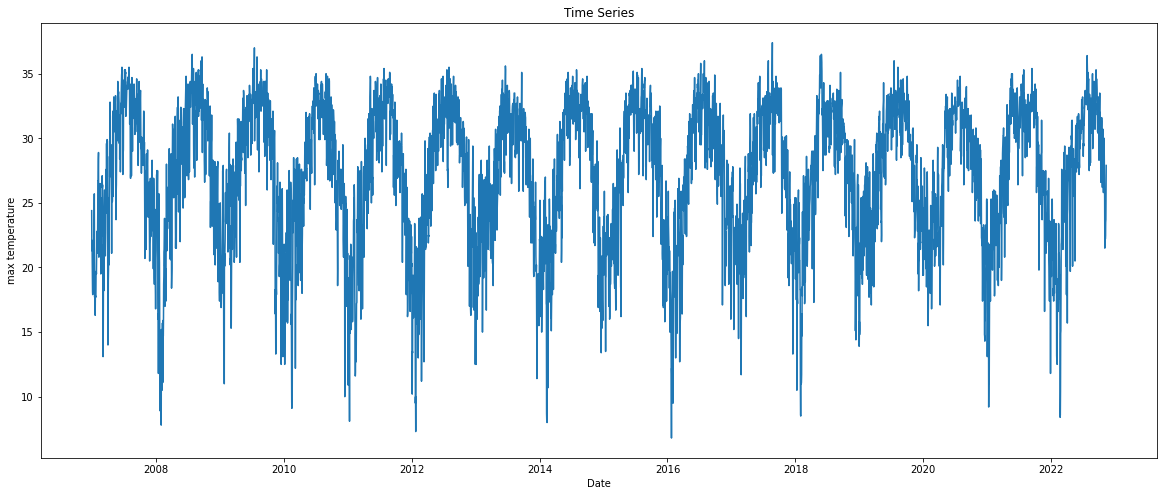

In [14]:
plt.figure(figsize=(20,8))
plt.plot(temp_max_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('max temperature')
plt.show()

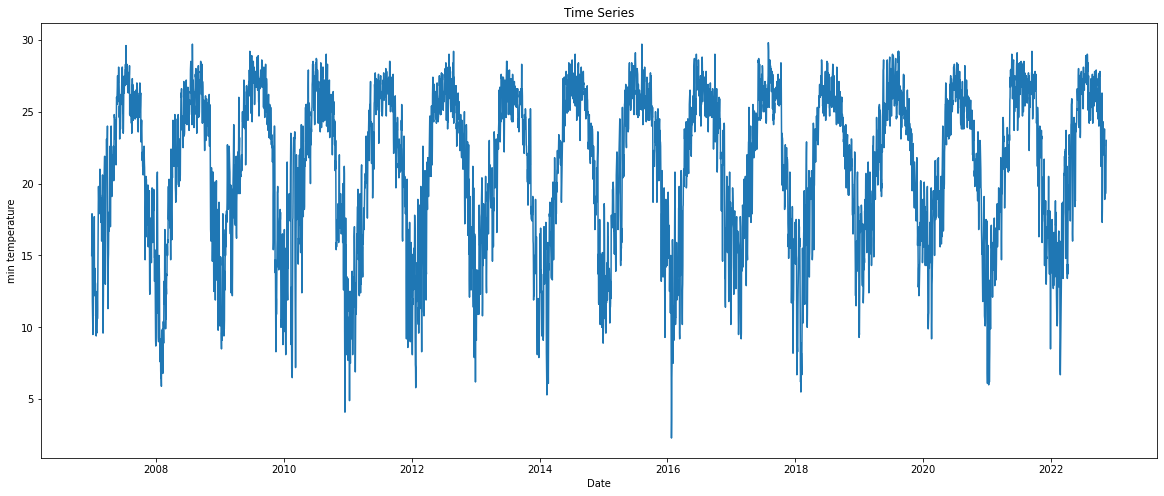

In [15]:
plt.figure(figsize=(20,8))
plt.plot(temp_min_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('min temperature')
plt.show()

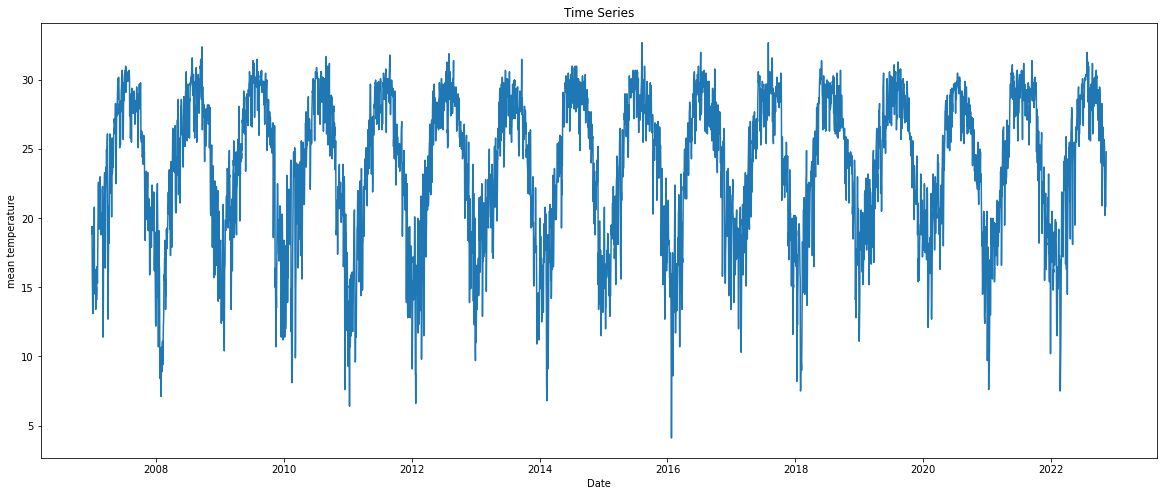

In [16]:
plt.figure(figsize=(20,8))
plt.plot(temp_mean_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('mean temperature')
plt.show()

In [17]:
temp_max_data = temp_max_data.values
temp_max_data = temp_max_data.astype('float32')

In [18]:
scaler= MinMaxScaler(feature_range=(-1,1))
max_sc = scaler.fit_transform(temp_max_data)


In [19]:
max_sc

array([[ 0.15032673],
       [-0.0522877 ],
       [ 0.        ],
       ...,
       [ 0.10457516],
       [ 0.30065358],
       [ 0.37908483]], dtype=float32)

In [20]:
timestep = 90

X= []
Y=[]


for i in range(len(max_sc)- (timestep)):
    X.append(max_sc[i:i+timestep])
    Y.append(max_sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 5602
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:]   

In [21]:
print(Xtrain.shape)
print(Xtest.shape)

(5602, 90, 1)
(101, 90, 1)


In [22]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape= (90,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 90, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

Epoch 1/50
176/176 [==============================] - 21s 97ms/step - loss: 0.0672
Epoch 2/50
176/176 [==============================] - 18s 100ms/step - loss: 0.0395
Epoch 3/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0355
Epoch 4/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0309
Epoch 5/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0255
Epoch 6/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0225
Epoch 7/50
176/176 [==============================] - 17s 96ms/step - loss: 0.0224
Epoch 8/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0219
Epoch 9/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0215
Epoch 10/50
176/176 [==============================] - 17s 96ms/step - loss: 0.0224
Epoch 11/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0219
Epoch 12/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0216


Text(0.5, 1.0, 'Model Accuracy')

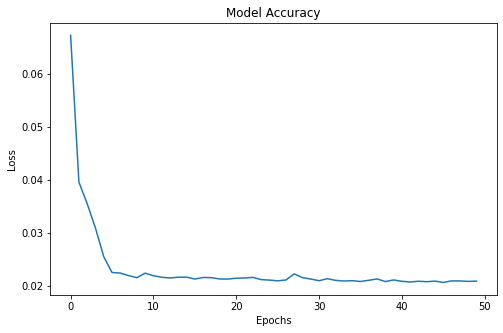

In [25]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [26]:
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

4/4 [==============================] - 1s 24ms/step


2.6621978

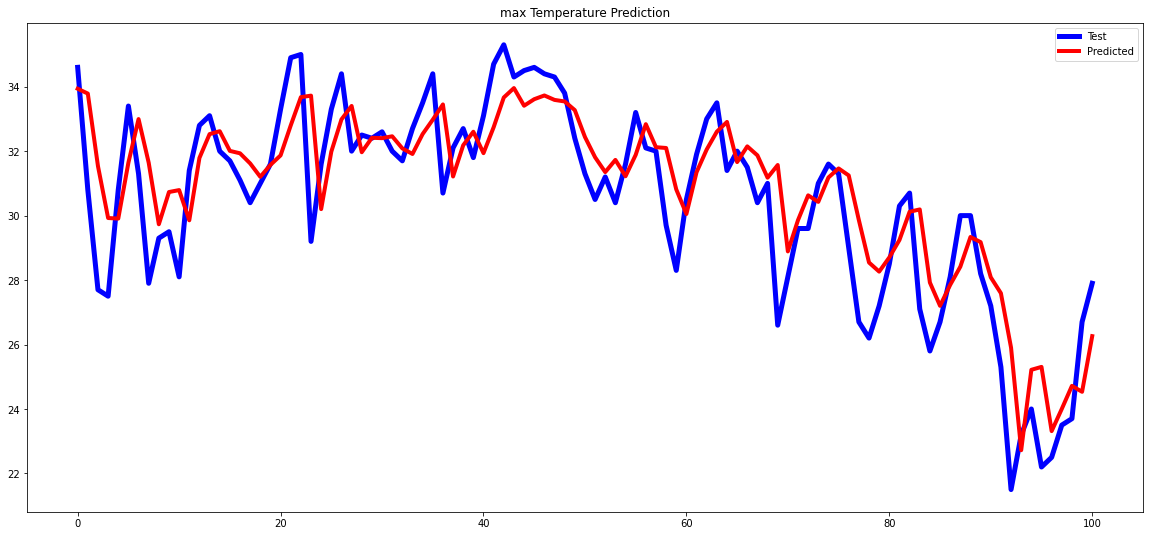

In [27]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("max Temperature Prediction")
plt.show()


In [28]:
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])

In [29]:
results = pd.concat([test,pred],axis=1)

In [30]:
results.head(9)

,Actual,Predict
0,34.599998,33.936913
1,30.799999,33.786465
2,27.700001,31.535072
3,27.500000,29.925577
4,30.799999,29.908062
5,33.400002,31.643288
6,31.300001,32.995747
7,27.900000,31.640648
8,29.299999,29.731236


In [31]:
def insert_end(Xin,new_input):
    #print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    #print ('After :\n', Xin)
    return Xin


In [32]:
temp_max_df

,max_temp
date,
2007-01-01,24.4
2007-01-02,21.3
2007-01-03,22.1
2007-01-04,20.8
2007-01-05,19.8
...,...
2022-11-06,22.5
2022-11-07,23.5
2022-11-08,23.7


In [33]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=60
forcast = []
Xin = []
Xin = Xtest[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    print(forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(temp_max_df.index[-1])+timedelta(days=i+1))

1/1 [==============================] - 0s 25ms/step
[0.27192903]
1/1 [==============================] - 0s 29ms/step
[0.27192903, 0.23802124]
1/1 [==============================] - 0s 26ms/step
[0.27192903, 0.23802124, 0.22367986]
1/1 [==============================] - 0s 30ms/step
[0.27192903, 0.23802124, 0.22367986, 0.21525885]
1/1 [==============================] - 0s 29ms/step
[0.27192903, 0.23802124, 0.22367986, 0.21525885, 0.20530993]
1/1 [==============================] - 0s 27ms/step
[0.27192903, 0.23802124, 0.22367986, 0.21525885, 0.20530993, 0.19204536]
1/1 [==============================] - 0s 28ms/step
[0.27192903, 0.23802124, 0.22367986, 0.21525885, 0.20530993, 0.19204536, 0.17790726]
1/1 [==============================] - 0s 27ms/step
[0.27192903, 0.23802124, 0.22367986, 0.21525885, 0.20530993, 0.19204536, 0.17790726, 0.16458885]
1/1 [==============================] - 0s 28ms/step
[0.27192903, 0.23802124, 0.22367986, 0.21525885, 0.20530993, 0.19204536, 0.17790726, 0.16458

In [34]:
forcasted_output=np.asanyarray(forcast)   
forcasted_output=forcasted_output.reshape(-1,1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [35]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [36]:
df_result

,Date,Forecasted
0,2022-11-11,26.260515
1,2022-11-12,25.741726
2,2022-11-13,25.522305
3,2022-11-14,25.393461
4,2022-11-15,25.241241
5,2022-11-16,25.038294
6,2022-11-17,24.821981
7,2022-11-18,24.618210
8,2022-11-19,24.440018
9,2022-11-20,24.294548


In [37]:
temp_min_data = temp_min_data.values
temp_min_data = temp_min_data.astype('float32')

In [38]:
min_scaler= MinMaxScaler(feature_range=(-1,1))
min_sc = min_scaler.fit_transform(temp_min_data)
min_sc

array([[-0.07636368],
       [ 0.07636368],
       [ 0.13454545],
       ...,
       [ 0.33090913],
       [ 0.40363634],
       [ 0.50545454]], dtype=float32)

In [39]:
timestep = 90

X_min= []
Y_min=[]


for i in range(len(min_sc)- (timestep)):
    X_min.append(min_sc[i:i+timestep])
    Y_min.append(min_sc[i+timestep])


X_min=np.asanyarray(X_min)
Y_min=np.asanyarray(Y_min)


k = 5602
X_min_train = X_min[:k,:,:]
X_min_test = X_min[k:,:,:]    
Y_min_train = Y_min[:k]    
Y_min_test= Y_min[k:]   

In [40]:
print(X_min_train.shape)
print(X_min_test.shape)

(5602, 90, 1)
(101, 90, 1)


In [41]:
model2 = Sequential()

model2.add(LSTM(32,activation = 'relu', input_shape= (90,1), return_sequences=True))
model2.add(LSTM(32, activation='relu', return_sequences=True))
model2.add(LSTM(32, activation='sigmoid', return_sequences=False))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

In [42]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 90, 32)            4352      
                                                                 
 lstm_4 (LSTM)               (None, 90, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [43]:
min_history = model2.fit(X_min_train,Y_min_train,epochs=50, verbose=1)

Epoch 1/50
176/176 [==============================] - 21s 98ms/step - loss: 0.0532
Epoch 2/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0317
Epoch 3/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0283
Epoch 4/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0264
Epoch 5/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0288
Epoch 6/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0229
Epoch 7/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0190
Epoch 8/50
176/176 [==============================] - 17s 99ms/step - loss: 0.0162
Epoch 9/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0150
Epoch 10/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0135
Epoch 11/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0131
Epoch 12/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0129
E

Text(0.5, 1.0, 'Model Accuracy')

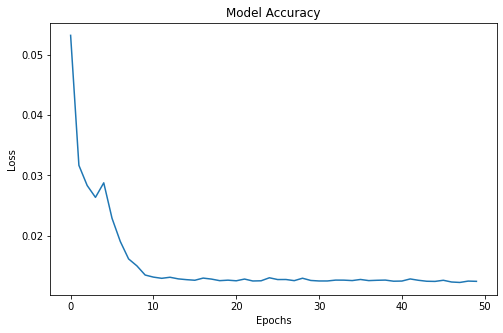

In [44]:
plt.figure(figsize=(8,5))
plt.plot(min_history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [45]:
min_preds= model2.predict(X_min_test)
min_preds = min_scaler.inverse_transform(min_preds)


Y_min_test=np.asanyarray(Y_min_test)  
Y_min_test=Y_min_test.reshape(-1,1) 
Y_min_test = min_scaler.inverse_transform(Y_min_test)


Y_min_train=np.asanyarray(Y_min_train)  
Y_min_train=Y_min_train.reshape(-1,1) 
Y_min_train = min_scaler.inverse_transform(Y_min_train)

mean_squared_error(Y_min_test,min_preds)

4/4 [==============================] - 1s 24ms/step


2.0476754

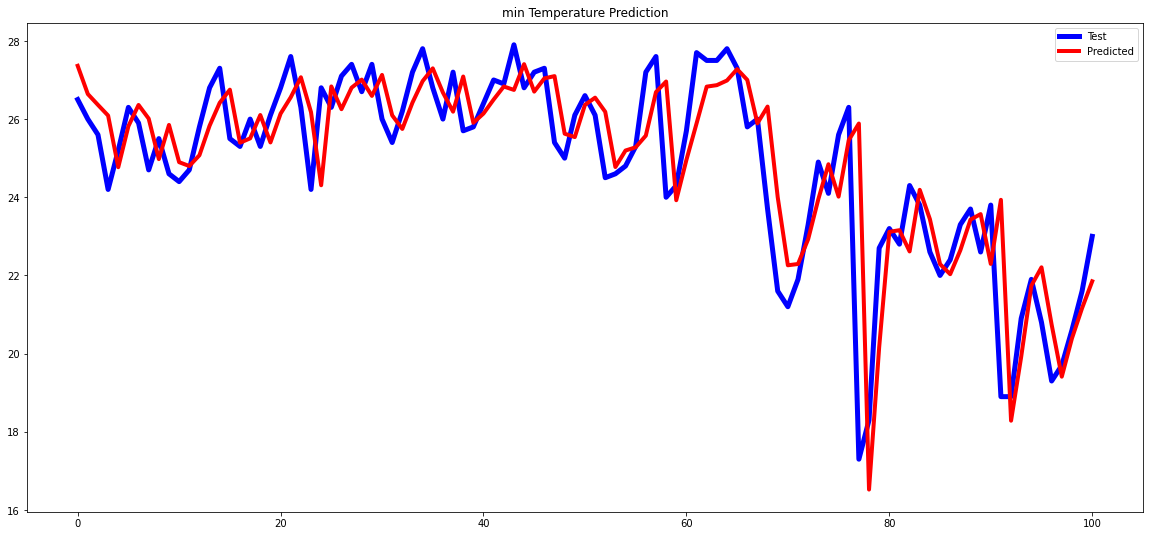

In [46]:
plt.figure(figsize=(20,9))
plt.plot(Y_min_test , 'blue', linewidth=5)
plt.plot(min_preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("min Temperature Prediction")
plt.show()


In [47]:
min_test = pd.DataFrame(Y_min_test,columns=['Actual'])
min_pred = pd.DataFrame(min_preds,columns=['Predict'])

In [48]:
min_results = pd.concat([min_test,min_pred],axis=1)

In [49]:
min_results.head(9)

,Actual,Predict
0,26.500000,27.362757
1,26.000000,26.640558
2,25.600000,26.362696
3,24.200001,26.089958
4,25.200001,24.768240
5,26.299999,25.818747
6,25.900000,26.361565
7,24.700001,26.011642
8,25.500000,24.975889


In [50]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=60
forcast2 = []
Xin = X_min_test[-1:,:,:]
time=[]
for i in range(future):
    out = model2.predict(Xin, batch_size=1)    
    forcast2.append(out[0,0]) 
    print(forcast2)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(temp_min_df.index[-1])+timedelta(days=i+1))

1/1 [==============================] - 0s 28ms/step
[0.42186177]
1/1 [==============================] - 0s 24ms/step
[0.42186177, 0.41958615]
1/1 [==============================] - 0s 28ms/step
[0.42186177, 0.41958615, 0.411094]
1/1 [==============================] - 0s 26ms/step
[0.42186177, 0.41958615, 0.411094, 0.40367603]
1/1 [==============================] - 0s 25ms/step
[0.42186177, 0.41958615, 0.411094, 0.40367603, 0.39913043]
1/1 [==============================] - 0s 25ms/step
[0.42186177, 0.41958615, 0.411094, 0.40367603, 0.39913043, 0.39712414]
1/1 [==============================] - 0s 31ms/step
[0.42186177, 0.41958615, 0.411094, 0.40367603, 0.39913043, 0.39712414, 0.39698547]
1/1 [==============================] - 0s 34ms/step
[0.42186177, 0.41958615, 0.411094, 0.40367603, 0.39913043, 0.39712414, 0.39698547, 0.3981104]
1/1 [==============================] - 0s 25ms/step
[0.42186177, 0.41958615, 0.411094, 0.40367603, 0.39913043, 0.39712414, 0.39698547, 0.3981104, 0.40000436]

In [51]:
min_forcasted2_output=np.asanyarray(forcast2)   
min_forcasted2_output=min_forcasted2_output.reshape(-1,1) 
min_forcasted2_output = min_scaler.inverse_transform(min_forcasted2_output) 

In [52]:
min_forcasted2_output = pd.DataFrame(min_forcasted2_output)
date = pd.DataFrame(time)
min_df_result = pd.concat([date,min_forcasted2_output],axis=1)
min_df_result.columns = "Date","Forecasted"

In [53]:
min_df_result

,Date,Forecasted
0,2022-11-11,21.850599
1,2022-11-12,21.819309
2,2022-11-13,21.702543
3,2022-11-14,21.600546
4,2022-11-15,21.538044
5,2022-11-16,21.510458
6,2022-11-17,21.508549
7,2022-11-18,21.524017
8,2022-11-19,21.550060
9,2022-11-20,21.581551
